In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Get input map

In [3]:
from scripts.spatial_network.perlin.run_entropy_maximisation_perlin_map import get_perlin_map
from scripts.spatial_layout import SpatialLayout
from scripts.interneuron_placement import plot_neural_sheet

ModuleNotFoundError: No module named 'scripts'

In [4]:
seed = 1
correlation_length = 200
map_size = 900
long_half = 100
short_half = 25

Ne = 3600
Ni = 400

Ne_per_row = int(np.sqrt(Ne))
Ni_per_row = int(np.sqrt(Ni))


In [6]:
input_map  = get_perlin_map(correlation_length, seed, map_size, Ne)
spatial_layout = SpatialLayout(input_map, Ne, Ni, long_half, short_half, map_size )

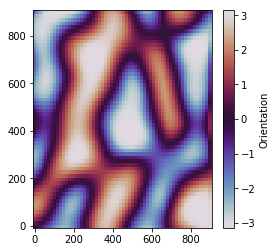

In [7]:
plot_neural_sheet(spatial_layout.ex_positions, spatial_layout.ex_tunings)

## Choose interneuron and get entropies

In [8]:
from scripts.interneuron_placement import Pickle, get_excitatory_phases_in_inhibitory_axon, get_correct_position_mesh

In [9]:
from scripts.spatial_layout import get_entropy

In [10]:
in_idx = 144

In [11]:
pos_x = spatial_layout.in_positions[in_idx][0]
pos_y = spatial_layout.in_positions[in_idx][1]

In [12]:
equivalent_radius = np.sqrt(long_half*short_half)
circular_axon = Pickle(pos_x, pos_y, equivalent_radius, equivalent_radius, 0)

In [13]:
neuron_positions = spatial_layout.ex_positions
neuron_tunings = spatial_layout.ex_tunings

In [14]:
number_of_phases = 36
phases = np.linspace(-np.pi/2, np.pi/2, number_of_phases, endpoint=False)

In [15]:
number_of_bins = 10
tuning_bins = np.linspace(-np.pi, np.pi, number_of_bins+1)
tunings = []
entropies = []
for phase in phases:
    axonal_cloud = Pickle(pos_x, pos_y, long_half, short_half, phase)
    tunings.append(get_excitatory_phases_in_inhibitory_axon(neuron_positions, neuron_tunings, axonal_cloud))
    entropies.append(get_entropy(axonal_cloud, neuron_positions, neuron_tunings, tuning_bins))

In [16]:
circular_entropy = get_entropy(circular_axon, neuron_positions, neuron_tunings, tuning_bins)

In [17]:
max_entropy = max(entropies)
max_phase = phases[np.argmax(entropies)]
max_id = np.argmax(entropies)

min_entropy = min(entropies)
min_phase = phases[np.argmin(entropies)]
min_id = np.argmin(entropies)


In [18]:
circular_tuning = get_excitatory_phases_in_inhibitory_axon(neuron_positions, neuron_tunings, circular_axon)

## Figures

In [19]:
import matplotlib

In [20]:
plt.style.use('../scripts/spatial_network/perlin/figures.mplstyle')

In [21]:
width = 4.0/2.54
height = 3.2/2.54

detail_size = 2.5*long_half

detail_x_low = pos_x-detail_size/2.0
detail_x_high = pos_x+detail_size/2.0
detail_y_low = pos_y-detail_size/2.0
detail_y_high = pos_y+detail_size/2.0

colormap = matplotlib.cm.get_cmap('hsv')

bar_colors =[colormap(value) for value in np.linspace(0,1,number_of_bins)]

X, Y = get_correct_position_mesh(spatial_layout.ex_positions)
head_dir_preference = np.array(spatial_layout.ex_tunings).reshape((Ne_per_row, Ne_per_row))

### Polar Interneuron

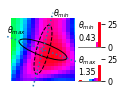

In [22]:
fig = plt.figure(figsize=(width,height))

ax_map = fig.add_axes([0.05,0.1,0.7*height/width,0.7])

ax_map.pcolor(X, Y, head_dir_preference, vmin=-np.pi, vmax=np.pi, cmap=colormap)

line_length = 1.2*detail_size
max_entropy_ell = Pickle(pos_x, pos_y, long_half, short_half, max_phase ).get_ellipse()

max_entropy_line = plt.Line2D([pos_x-np.cos(max_phase)*line_length/2.0, pos_x+np.cos(max_phase)*line_length/2.0],[pos_y-np.sin(max_phase)*line_length/2.0, pos_y+np.sin(max_phase)*line_length/2.0] )
max_entropy_line.set_linestyle('dotted')
max_entropy_line.set_clip_on(False)


min_entropy_ell = Pickle(pos_x, pos_y, long_half, short_half, min_phase ).get_ellipse()
min_entropy_ell.set_linestyle('dashed')

min_entropy_line = plt.Line2D([pos_x-np.cos(min_phase)*line_length/2.0, pos_x+np.cos(min_phase)*line_length/2.0],[pos_y-np.sin(min_phase)*line_length/2.0, pos_y+np.sin(min_phase)*line_length/2.0] )
min_entropy_line.set_linestyle('dotted')
min_entropy_line.set_clip_on(False)


ax_map.add_artist(max_entropy_ell)
ax_map.add_artist(max_entropy_line)
ax_map.add_artist(min_entropy_ell)
ax_map.add_artist(min_entropy_line)


ax_map.set_xlim(detail_x_low, detail_x_high)
ax_map.set_ylim(detail_y_low, detail_y_high)

ax_map.spines["right"].set_visible(False)
ax_map.spines["left"].set_visible(False)
ax_map.spines["top"].set_visible(False)
ax_map.spines["bottom"].set_visible(False)
ax_map.xaxis.set_ticks([])
ax_map.yaxis.set_ticks([])

ax_map.text(pos_x-np.cos(max_phase)*line_length/2.0, pos_y-np.sin(max_phase)*line_length/2.0, "$\\theta_{max}$", va='bottom', ha='left')
ax_map.text(pos_x+np.cos(min_phase)*line_length/2.0, pos_y+np.sin(min_phase)*line_length/2.0, "$\\theta_{min}$", va='center', ha='left')


ax_dist_max = fig.add_axes([0.05+0.7*height/width+0.03, 0.1, 1-0.75*height/width-0.05-0.05-0.1, 0.27])
n_max_entropy, _, bars = ax_dist_max.hist(tunings[max_id], bins=number_of_bins, range=(-np.pi, np.pi))
for bar, bar_color in zip(bars, bar_colors):
    bar.set_color(bar_color)
ax_dist_max.text(0,1.2,"$\\theta_{max}$\n"+"{:.2f}".format(entropies[max_id]), transform=ax_dist_max.transAxes, va='top')
    
ax_dist_min = fig.add_axes([0.05+0.7*height/width+0.03, 0.48, 1-0.75*height/width-0.05-0.05-0.1, 0.27])
n_min_entropy, _, bars = ax_dist_min.hist(tunings[min_id], bins=number_of_bins, range=(-np.pi, np.pi))
for bar, bar_color in zip(bars, bar_colors):
    bar.set_color(bar_color)
ax_dist_min.text(0,1.2,"$\\theta_{min}$\n"+"{:.2f}".format(entropies[min_id]), transform=ax_dist_min.transAxes, va='top')

for ax in [ax_dist_max, ax_dist_min]:
    ax.set_ylim(0, max(max(n_max_entropy), max(n_min_entropy))) 
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.xaxis.set_ticks([])
    ax.yaxis.tick_right()

fig.savefig("../figures/figure_4_paper_perlin/B_ii_max_entropy_rule_polar_ins.png")
    

### Circular Interneuron

In [25]:
from scripts.spatial_network.perlin.figure_utils import add_length_scale

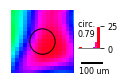

In [36]:
fig = plt.figure(figsize=(width,height))

ax_map = fig.add_axes([0.05,0.1,0.7*height/width,0.7])

ax_map.pcolor(X, Y, head_dir_preference, vmin=-np.pi, vmax=np.pi, cmap=colormap)

circle = Pickle(pos_x, pos_y, equivalent_radius, equivalent_radius, 0).get_ellipse()


ax_map.add_artist(circle)

ax_map.set_xlim(detail_x_low, detail_x_high)
ax_map.set_ylim(detail_y_low, detail_y_high)

ax_map.spines["right"].set_visible(False)
ax_map.spines["left"].set_visible(False)
ax_map.spines["top"].set_visible(False)
ax_map.spines["bottom"].set_visible(False)
ax_map.xaxis.set_ticks([])
ax_map.yaxis.set_ticks([])

add_length_scale(ax_map, 100, detail_x_high+30, detail_x_high+10+100, detail_y_low+40, detail_y_low+40)


ax_dist = fig.add_axes([0.05+0.7*height/width+0.03, 0.375, 1-0.75*height/width-0.05-0.05-0.1, 0.27])
n_circle, _, bars = ax_dist.hist(circular_tuning, bins=number_of_bins, range=(-np.pi, np.pi))
for bar, bar_color in zip(bars, bar_colors):
    bar.set_color(bar_color)
    
ax_dist.text(0,1.2,"circ. \n{:.2f}".format(circular_entropy), transform=ax_dist.transAxes, va='top')
    

for ax in [ax_dist]:
    ax.set_ylim(0, max(max(n_max_entropy), max(n_min_entropy))) 
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.xaxis.set_ticks([])
    ax.yaxis.tick_right()
    

fig.savefig("../figures/figure_4_paper_perlin/B_ii_max_entropy_rule_circular_in.png")
    